# Model validation
Testing models against holdout set not used in training.  
501 positive files, 1539 negative files, randomly selected across all 11 deployments.  

In this holdout testing, vX was identified as the best model: highest recall _and_ other classification metrics.  There is a degree of randomness to neural networks, which can cause variation in performance even with the same architecture and the same training data. This variation will absolutely be exacerbated by our subset-mini-batch training format that we had to implement.  It is good practice to fit the model many times and average all scores for reporting.  

Thus, vX was vetted through reinstantiation and training on the same data (here, 5 fits each for both augmented and no-augmented data).  Two of the five re-fits received the subsets in reverse order in order to mix it up a little.  The validation process below contains all 10 of these vX models, and the single fits for all other versions (v2-9, vXI).

The architectures for each version are summarized in the readme.

---
Citations:  
Dennis T, [Confusion Matrix Visualization](https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea)

In [1]:
import tensorflow as tf
import pandas as pd
import seaborn as sns
import os
import numpy as np
import pickle
import gc

#### Import holdout set and label with positive/negative.
Similar to process in notebooks for model training.

In [2]:
#import holdout set
in_path = '../scratch_data/holdout/'
os.listdir(in_path)

['holdout_1_neg.pkl', 'holdout_1_pos.pkl', 'positives', 'negatives']

In [3]:
target_files = [i for i in os.listdir(in_path) if 'pkl' in i]
target_files

['holdout_1_neg.pkl', 'holdout_1_pos.pkl']

In [4]:
X_holdout = []
y_holdout = []
for i in target_files:
    with open (in_path + i, mode = 'rb') as f:
        temp = pickle.load(f)
        X_holdout += temp
        if 'pos' in i:
            y_holdout += [1]*len(temp)
        else:
            y_holdout += [0]*len(temp)

In [5]:
#standard scaler to match training data
X_holdout = [((i-np.mean(i))/np.std(i)) for i in X_holdout]

#recast for model input
X_holdout = np.array(X_holdout)
y_holdout = np.array(y_holdout)
X_holdout = X_holdout.reshape(X_holdout.shape[0], 610, 368, 1)

In [6]:
mod_path = '../data/models/'
os.listdir(mod_path)

['v6_masked',
 'v5_nomasks',
 'vX_again_masked',
 'vXI_masked',
 'v2_dnc',
 'vX_third_masked',
 'vX_again_nomasks',
 'v4_nomasks',
 'v4_masked',
 'vX_third_nomasks',
 'vXI_nomasks',
 'v6_nomasks',
 'v7_nomasks',
 'vX_rev_nomasks',
 'vX_rev2_nomasks',
 'v9_masked',
 'v5_masked',
 'vX_rev2_masked',
 'vX_rev_masked',
 'histories',
 'vX_original_masked',
 'vX_original_nomasks',
 'v9_nomasks']

#### Define function to evaluate each model on holdout data and configure results in a dataframe:

In [7]:
def group_eval_to_df(mod_path, X_val, y_val):
    mod_list = [i for i in os.listdir(mod_path) if 'hist' not in i]
    
    list_for_df = []
    
    for m in mod_list:
        model = tf.keras.models.load_model(mod_path+m)
        score = model.evaluate(X_val, y_val, verbose=0)
        metrics = model.metrics_names
        for i in range(len(model.metrics_names)):
            row = [m, model.metrics_names[i], score[i]]
            list_for_df.append(row)
    
    df = pd.DataFrame(list_for_df, columns = ['model', 'metric', 'score'])
    df = df.set_index(['model', 'metric'])['score'].unstack()
    df = df[['recall', 'acc', 'precision', 'loss']]
    return df

#### Evaluate all models at once:
Read something recreational for 40 seconds you've earned it

In [8]:
holdout_scores = group_eval_to_df(mod_path, X_holdout, y_holdout)
holdout_scores

metric,recall,acc,precision,loss
model,,,,
v2_dnc,0.000,0.754661,0.000000,0.557160
v4_masked,0.360,0.786065,0.608108,2.649781
v4_nomasks,0.330,0.773307,0.565068,2.661591
v5_masked,0.292,0.786065,0.640351,3.221844
v5_nomasks,0.304,0.773307,0.571429,3.224825
v6_masked,0.394,0.781158,0.579412,22.098425
v6_nomasks,0.374,0.778214,0.573620,22.140457
v7_nomasks,0.376,0.700196,0.386037,11228.722656
v9_masked,0.378,0.780177,0.579755,24.220379


### 'Masked' generally outperforms unmasked
The above is helpful output for comparing models sequentially, and with their masked counterpart. It appears at first glance that the models trained with the addition of augmented data usually outperformed the version not exposed to augmented data.  Sorting by recall confirms that 7 of the top 10 models were 'masked'.  Sorting also shows that vX consistently beat out other models, but occasionaly it took a real dive: iterations of vX hold all of the top 5 positions, but also 2 of the bottom 3:

In [9]:
holdout_scores.sort_values('recall', ascending=False)

metric,recall,acc,precision,loss
model,,,,
vX_again_masked,0.526,0.796860,0.597727,0.478910
vX_rev_nomasks,0.440,0.764475,0.523810,0.513241
vX_third_masked,0.426,0.791953,0.608571,0.469696
vX_original_masked,0.422,0.795388,0.622419,0.454362
vX_third_nomasks,0.410,0.765456,0.528351,0.525266
vXI_masked,0.402,0.788518,0.603604,0.455632
v6_masked,0.394,0.781158,0.579412,22.098425
vX_rev_masked,0.390,0.791462,0.619048,0.470176
vXI_nomasks,0.388,0.784593,0.593272,0.498613


In [10]:
holdout_scores.reset_index(inplace=True, drop=False)

#### Take a closer look at model vX:

In [11]:
vx = holdout_scores[holdout_scores['model'].str.contains('vX_')].copy()
vx.sort_values('recall', ascending=False, inplace=True)
vx.reset_index(inplace=True, drop=True)
vx.rename_axis(None, axis=1, inplace=True) #get rid of 'metric' as index title bc it bugs
vx

,model,recall,acc,precision,loss
0,vX_again_masked,0.526,0.796860,0.597727,0.478910
1,vX_rev_nomasks,0.440,0.764475,0.523810,0.513241
2,vX_third_masked,0.426,0.791953,0.608571,0.469696
3,vX_original_masked,0.422,0.795388,0.622419,0.454362
4,vX_third_nomasks,0.410,0.765456,0.528351,0.525266
5,vX_rev_masked,0.390,0.791462,0.619048,0.470176
6,vX_rev2_nomasks,0.368,0.778214,0.575000,0.509056
7,vX_original_nomasks,0.310,0.783611,0.617530,0.510558
8,vX_again_nomasks,0.254,0.776251,0.604762,0.486967
9,vX_rev2_masked,0.238,0.794897,0.762821,0.464661


In [12]:
# reformat for groupby
vx[['model', 'iteration', 'mask']] = vx['model'].str.split('_', expand=True)
vx.sort_values('recall', ascending=False, inplace=True)
vx

,model,recall,acc,precision,loss,iteration,mask
0,vX,0.526,0.796860,0.597727,0.478910,again,masked
1,vX,0.440,0.764475,0.523810,0.513241,rev,nomasks
2,vX,0.426,0.791953,0.608571,0.469696,third,masked
3,vX,0.422,0.795388,0.622419,0.454362,original,masked
4,vX,0.410,0.765456,0.528351,0.525266,third,nomasks
5,vX,0.390,0.791462,0.619048,0.470176,rev,masked
6,vX,0.368,0.778214,0.575000,0.509056,rev2,nomasks
7,vX,0.310,0.783611,0.617530,0.510558,original,nomasks
8,vX,0.254,0.776251,0.604762,0.486967,again,nomasks
9,vX,0.238,0.794897,0.762821,0.464661,rev2,masked


### Confusion matrix
Though we just evaluated models en masse on the holdout data (model.evaluate), model.predict() consistently breaks, possibly due to a [memory leak](https://github.com/tensorflow/tensorflow/issues/44711). Unfortunately, that means we cannot view individual files that are being misclassified. But since we have three classification metrics and know the true number of positives and negatives in the holdout set, we can at least back calculate TN, FP, FN, TP to build a confusion matrix manually.  

Given:

* accuracy = (tp + tn) / (tp + tn + fp + fn) = (tp + tn) / total
* recall = tp / (tp + fn) = tp / tot_pos
* precision = tp / (tp + fp)   

#### First, assess the best model: vX_again_masked
(the second fitting of vX, training with inclusion of augmented data)

In [13]:
tot_pos = 501
tot_neg = 1539

recall = vx['recall'][0]
prec = vx['precision'][0]
acc = vx['acc'][0]

# since recall = tp/tot_p
tp = recall * tot_pos

# knowing tp, and  prec = tp/(tp+fp) -> prec(tp + fp) = tp -> prec*fp = tp-(prec*tp)
fp = (tp * (1-prec)) / prec

# total_negatives = true negs + false positives
tn = tot_neg - fp

#total_positives = true positives + false negatives
fn = tot_pos - tp

print(f'holdout positives: {tot_pos}\nholdout negatives: {tot_neg}\n\n')
print(f'true negatives = {round(tn)}\nfalse positives = {round(fp)}\nfalse negatives = {round(fn)}\ntrue positives = {round(tp)}')

holdout positives: 501
holdout negatives: 1539


true negatives = 1362
false positives = 177
false negatives = 237
true positives = 264


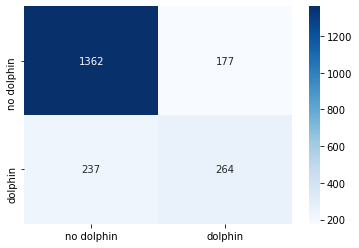

In [14]:
confusion_matrix = np.array([[round(tn), round(fp)],[round(fn), round(tp)]])
sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='.0f',
            xticklabels =['no dolphin', 'dolphin'], yticklabels=['no dolphin', 'dolphin']);

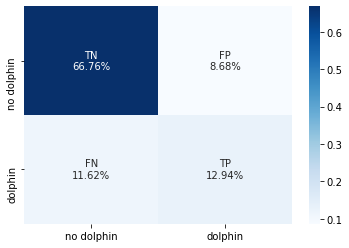

In [15]:
# custom annotation code from Dennis T, 'Confusion Matrix Visualization'
cats = ['TN', 'FP', 'FN', 'TP']
percents = ['{0:.2%}'.format(i) for i in confusion_matrix.flatten()/np.sum(confusion_matrix)]
labs = [f'{i}\n{j}' for i,j in zip(cats, percents)]
labs = np.array(labs).reshape(2,2)

sns.heatmap(confusion_matrix/np.sum(confusion_matrix), annot=labs, cmap='Blues', fmt='',
            xticklabels =['no dolphin', 'dolphin'], yticklabels=['no dolphin', 'dolphin']);

Looking at the above 'best model' is a bit misleading. 

vX was fit 5 times with unaugmented data and 5 times with augmented data included; 2 of 5 fits reversed the order of subset exposure. The variation across trainings is substantial. While the **best** iteration above achieved 53% recall, the **average** recall for this architecture on this validation data is a more accurate basis for expectations.

#### Examining aggregate performance

In [16]:
grouped = vx.groupby('mask').mean() #bummer
grouped

,recall,acc,precision,loss
mask,,,,
masked,0.4004,0.794112,0.642117,0.467561
nomasks,0.3564,0.773602,0.569890,0.509018


In [17]:
tot_pos = 501
tot_neg = 1539

recall = grouped['recall'][0]
prec = grouped['precision'][0]
acc = grouped['acc'][0]

tp_avg = recall * tot_pos
fp_avg = (tp_avg * (1-prec)) / prec
tn_avg = tot_neg - fp_avg
fn_avg = tot_pos - tp_avg

print(f'holdout positives: {tot_pos}\nholdout negatives: {tot_neg}\n')
print('vX_masked performance\nAverage across 5 fits:')
print(f'TN = {round(tn_avg)}\nFP = {round(fp_avg)}\nFN = {round(fn_avg)}\nTP = {round(tp_avg)}')

holdout positives: 501
holdout negatives: 1539

vX_masked performance
Average across 5 fits:
TN = 1427
FP = 112
FN = 300
TP = 201


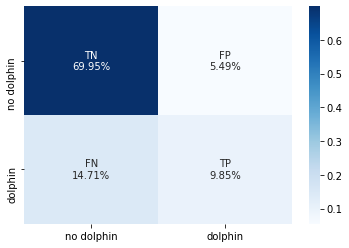

In [18]:
avg_cm = np.array([[round(tn_avg), round(fp_avg)],[round(fn_avg), round(tp_avg)]])
# custom annotation code from Dennis T, 'Confusion Matrix Visualization'
cats = ['TN', 'FP', 'FN', 'TP']
percents = ['{0:.2%}'.format(i) for i in avg_cm.flatten()/np.sum(avg_cm)]
labs = [f'{i}\n{j}' for i,j in zip(cats, percents)]
labs = np.array(labs).reshape(2,2)

sns.heatmap(avg_cm/np.sum(avg_cm), annot=labs, cmap='Blues', fmt='',
            xticklabels =['no dolphin', 'dolphin'], yticklabels=['no dolphin', 'dolphin']);

## Conclusions
As mentioned 400 times so far, our priority metric is recall, also known as the _true positive rate_.  Though a 1:3 (p:n) ratio was used in training and validating this model, the true split in the cumulative data across deployments was 97% negative files and only 3% positive. Given the rarity of a positive, it is critical to identify every one, even at the expense of accumulating _false_ positives. As a former researcher that did this manually, if a program could grab say 10% of the total dataset and assure me that the 3% dolphin encounters were in there, and my role now was to go through this subset to weed out the false positives, that would still drastically reduce my workload. With a high false positive rate like that, it may have low specificity, precision, and accuracy on paper, but it would still be _useful_. However, if there is also a significant false negatives rate which must be vetted manually, there is no utility.  

Unfortunately, in our best performing model, we still have a formidable percentage of false negatives. The max recall of 53% means that 47% of the positive dolphin files are not caught.  

The aggregate performance over 5 fits is lower still: 40% recall, so 60% of dolphin files misclassified as no_dolphin. 

---
The CNN architectures explored here do yield an average accuracy of 79.4%, consistently outperforming the baseline 75%.  For the final model vetted here (vX), exposing the model to augmented data during training yielded improved performance across all performance metrics. This was not necessarily true for all models tested, but the majority (70%) follow the same pattern. However, despite better-than-baseline, the number of false negatives needs to be significantly reduced for this model to be implemented as a research tool. 

---
#### Recommended next steps
* Get more positive files! A burgeoned minority would help greatly.
    * The data suppliers are willing to contribute, so novel positive files is a realistic possibility
    * In leiu of new positives, fabricating more positives by stacking pos/neg or pos/pos could help balance classes artificially
* Reinstantiate and retrain other competitive models in this line up: given the variation seen in vX refitting, it may be that another version here is equally competitive or better when averaging multiple fits.
* Use a platform or machine that can execute model.predict() in order to identify what misclassified files look like: are they dominated by whale calls or anthropogenic sounds, or just empty ambient files? Can this guide filter selection or spectrogram preprocessing techniques?
* With access to more memory and GPU:
    * Double the number of filters in each conv2d layer of the superior model.
    * Deepen the NN: related literature points to VGG-19, ResNet-50, AlexNet as deep-layer NNs that have been employed for marine mammal acoustic tasks with better success
        * there are even keras supported versions of [VGG-19](https://keras.io/api/applications/vgg/) and [ResNet-50](https://keras.io/api/applications/resnet/), but they will require significant tuning and/or gridsearching to tailor to spectrograms. Though not a pre-existing keras architecture, there are also examples of [how to code AlexNet for tensorflow](https://analyticsindiamag.com/hands-on-guide-to-implementing-alexnet-with-keras-for-multi-class-image-classification/).
    * Explore the other spectrogram preprocessing parameters recommended at the end of notebook 2